# Quantum Computing Machine Learning Project

Authors: **Shpetim Veseli**, **Michael Voemel**

In [1]:
import numpy
print(numpy.version.version)
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Qiskit Imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.utils import algorithm_globals

1.26.4


In [2]:
# Configuration
algorithm_globals.random_seed = 42
np.random.seed(42)

In [3]:
# ==========================================
# STEP 1: LOAD DATA FROM PENNYLANE
# ==========================================

# Load the dataset
ds_list = qml.data.load("other", name="binarized-mnist")
ds = ds_list[0]

# Extract arrays
X_train_full = np.array(ds.train['inputs'])
y_train_full = np.array(ds.train['labels'])
X_test_full = np.array(ds.test['inputs'])
y_test_full = np.array(ds.test['labels'])

print(f"Original Training Data Shape: {X_train_full.shape}")
print(f"Original Labels Shape: {y_train_full.shape}")

Original Training Data Shape: (50000, 784)
Original Labels Shape: (50000,)


In [4]:
# ==========================================
# STEP 2: PREPROCESSING (CRITICAL STEP)
# ==========================================

# CONSTRAINT: Quantum simulations are slow. 
# We will filter the dataset to only classify two digits (e.g., 0 vs 1)
# and reduce the number of samples for the sake of simulation time.

def filter_data(X, y, class_a, class_b, limit=None):
    mask = (y == class_a) | (y == class_b)
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Remap labels to 0 and 1 for binary classification
    y_filtered = np.where(y_filtered == class_a, 0, 1)
    
    if limit:
        return X_filtered[:limit], y_filtered[:limit]
    return X_filtered, y_filtered

# Use digits 0 and 1
X_train_bin, y_train_bin = filter_data(X_train_full, y_train_full, 0, 1, limit=500)
X_test_bin, y_test_bin = filter_data(X_test_full, y_test_full, 0, 1, limit=100)

print(f"\nFiltered subset (0 vs 1): {len(X_train_bin)} training samples")


Filtered subset (0 vs 1): 500 training samples


In [5]:
# ==========================================
# STEP 3: DIMENSIONALITY REDUCTION (PCA)
# ==========================================

# Quantum computers cannot easily take 784 inputs. We reduce this to 4 features
# so we only need 4 qubits.
n_dim = 4

pca = PCA(n_components=n_dim)
scaler = StandardScaler()

# Fit PCA on training data
X_train_pca = pca.fit_transform(X_train_bin)
X_test_pca = pca.transform(X_test_bin)

# Scale data to range roughly [-1, 1] for better quantum rotation encoding
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

print(f"Data compressed from 784 dimensions to {n_dim} dimensions for Quantum processing.")

Data compressed from 784 dimensions to 4 dimensions for Quantum processing.


In [6]:
# ==========================================
# STEP 4: CLASSICAL APPROACH (Neural Network)
# ==========================================
print("\n--- Training Classical Neural Network ---")

# We use a standard MLP (Multi-Layer Perceptron)
# We train it on the FULL 784 dimensions to represent a "Standard Classical Benchmark"
clf_classical = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)

clf_classical.fit(X_train_bin, y_train_bin)
y_pred_classical = clf_classical.predict(X_test_bin)
acc_classical = accuracy_score(y_test_bin, y_pred_classical)

print(f"Classical NN Accuracy (on 784 features): {acc_classical:.4f}")


--- Training Classical Neural Network ---
Classical NN Accuracy (on 784 features): 1.0000


In [7]:
# ==========================================
# STEP 5: QUANTUM APPROACH (Qiskit VQC)
# ==========================================

print("\n--- Training Quantum Neural Network (VQC) ---")

# 5.1 Define the Feature Map (Encodes classical data into quantum state)
# ZZFeatureMap is a standard choice for injecting data into qubits
feature_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear')

# 5.2 Define the Ansatz (The trainable part of the quantum circuit)
# RealAmplitudes consists of Ry rotations and entangling gates
ansatz = RealAmplitudes(num_qubits=n_dim, reps=2)

# 5.3 Define the Optimizer
optimizer = COBYLA(maxiter=100)

# 5.4 Build the VQC (Variational Quantum Classifier)
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    loss='cross_entropy'
)

# Train the VQC (This takes time on a simulator!)
# We use the PCA-reduced data here
import time
start_time = time.time()
vqc.fit(X_train_pca, y_train_bin)
end_time = time.time()

print(f"Quantum Training time: {end_time - start_time:.2f} seconds")

# Evaluate
y_pred_quantum = vqc.predict(X_test_pca)
acc_quantum = accuracy_score(y_test_bin, y_pred_quantum)

print(f"Quantum VQC Accuracy (on {n_dim} PCA features): {acc_quantum:.4f}")

/var/folders/ll/lryt7tpj1fq6_tb46tcwnlf00000gn/T/ipykernel_73894/3292912515.py:9: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear')
/var/folders/ll/lryt7tpj1fq6_tb46tcwnlf00000gn/T/ipykernel_73894/3292912515.py:13: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=n_dim, reps=2)
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.



--- Training Quantum Neural Network (VQC) ---
Quantum Training time: 76.48 seconds
Quantum VQC Accuracy (on 4 PCA features): 0.6900


     ┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                               ├
«     │                                                                                │
«q_1: ┤1                                                                               ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) │
«q_2: ┤2                                                                               ├
«     │                                                      

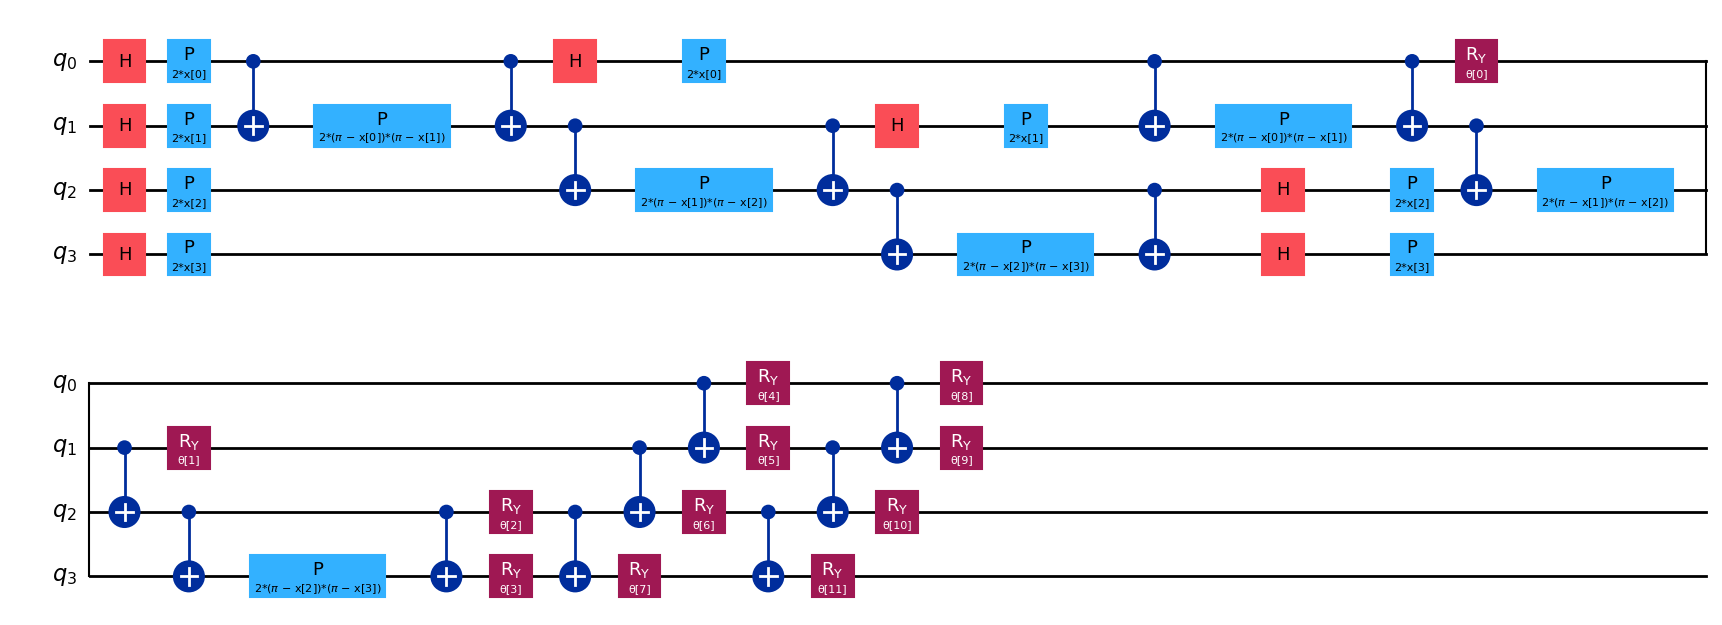

In [8]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(n_dim)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

print(qc)                 # text form
qc.decompose().draw("mpl")  # nice diagram (needs matplotlib)


--- Final Comparison ---
Classical (784 features): 100.00%
Quantum   (4 features)  : 69.00%


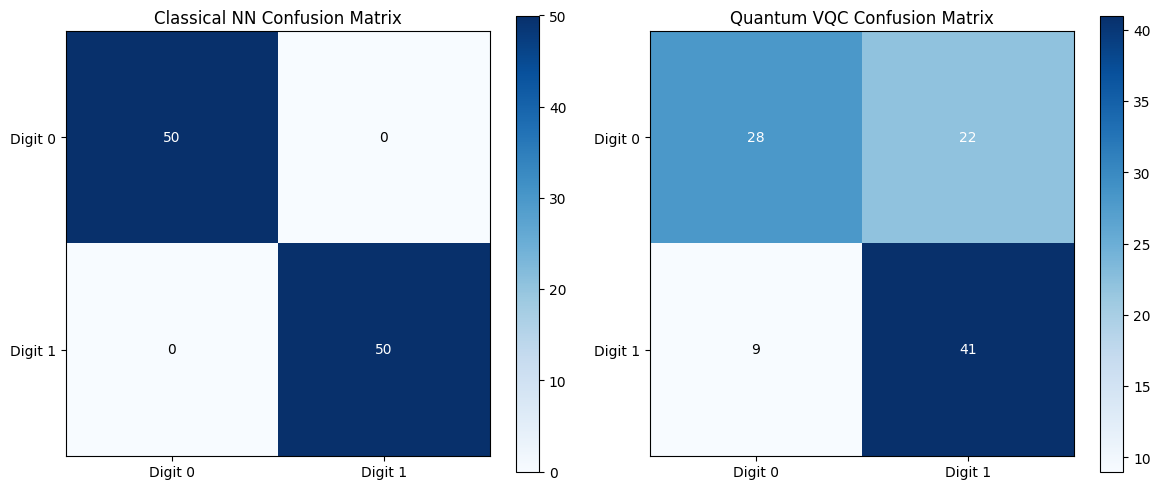

In [9]:
# ==========================================
# STEP 6: COMPARISON & VISUALIZATION
# ==========================================

print("\n--- Final Comparison ---")
print(f"Classical (784 features): {acc_classical * 100:.2f}%")
print(f"Quantum   (4 features)  : {acc_quantum * 100:.2f}%")

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm_classic = confusion_matrix(y_test_bin, y_pred_classical)
cm_quantum = confusion_matrix(y_test_bin, y_pred_quantum)

def plot_cm(ax, cm, title):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(['Digit 0', 'Digit 1'])
    ax.set_yticklabels(['Digit 0', 'Digit 1'])
    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

plot_cm(ax1, cm_classic, "Classical NN Confusion Matrix")
plot_cm(ax2, cm_quantum, "Quantum VQC Confusion Matrix")

plt.tight_layout()
plt.show()